In [1]:
%matplotlib inline

In [2]:
from matplotlib.pylab import *

In [3]:
# repo = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master"
# style.use("results/style_sheet.mplstyle")
rc('figure', dpi=300)
rc('figure', figsize=(8, 4))
rc('savefig', bbox='tight')
plt.rcParams.update({'font.size': 16})

import numpy as np
import torch
import torch.nn as nn
from models import resnet18_narrow as resnet18
from utils import get_loader
from utils.train_utils import AverageMeter, accuracy
import argparse
from sklearn.model_selection import ParameterGrid
import pickle
from tqdm import tqdm 
import copy
import glob
import numpy as np
import scipy
import copy

In [10]:
all_measures = ["eig_max", "fro_norm", "eig_trace", "d_eff", "eps_flat", "pac_bayes", "fim", "shannon_entropy", "local_entropy_grad_norm", "low_pass"]
labels = ["$\lambda_{max}(H)$", "$||H||_{F}$", "Trace(H)", "$d_{eff}$", "$\epsilon$ sharpness", "$\mu_{PAC-Bayes}$", "FRN", "Shannon","$\mu_{LE}$", "LPF"]

widths = sort([1, 3, 5, 7] + list(range(4, 60, 2)))

acc = []
gen_gap = []
sharpness = np.zeros((len(all_measures), len(widths))) # measures x noise x seed 

for j, w in enumerate(widths):
    fol = f"checkpoints/cifar10_dd/resnet_dd_{w}/run_ms_0/measures.pkl"
    with open(fol, 'rb') as f:
        mtr = pickle.load(f)
    acc.append(1 - mtr["val_acc"]/100)
    gen_gap.append(np.abs(100 - mtr["val_acc"]))
    for i,meas in enumerate(all_measures, 0):
        if meas == 'eig_max' or meas == "d_eff":
            fol = f"checkpoints/cifar10_dd/resnet_dd_{w}/run_ms_0/eig_val.npy"
            eig_val = np.load(fol)
            if meas == 'eig_max': sharpness[i,j] = np.max(eig_val)
            elif meas == 'd_eff': sharpness[i,j] = np.sum(eig_val / (eig_val + 1))
        else:
            sharpness[i,j] = np.abs(mtr[meas])
# x = x - x.min(1).reshape(-1, 1)
sharpness= sharpness/sharpness.max(1).reshape(-1,1)
gen_gap = np.array(gen_gap)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


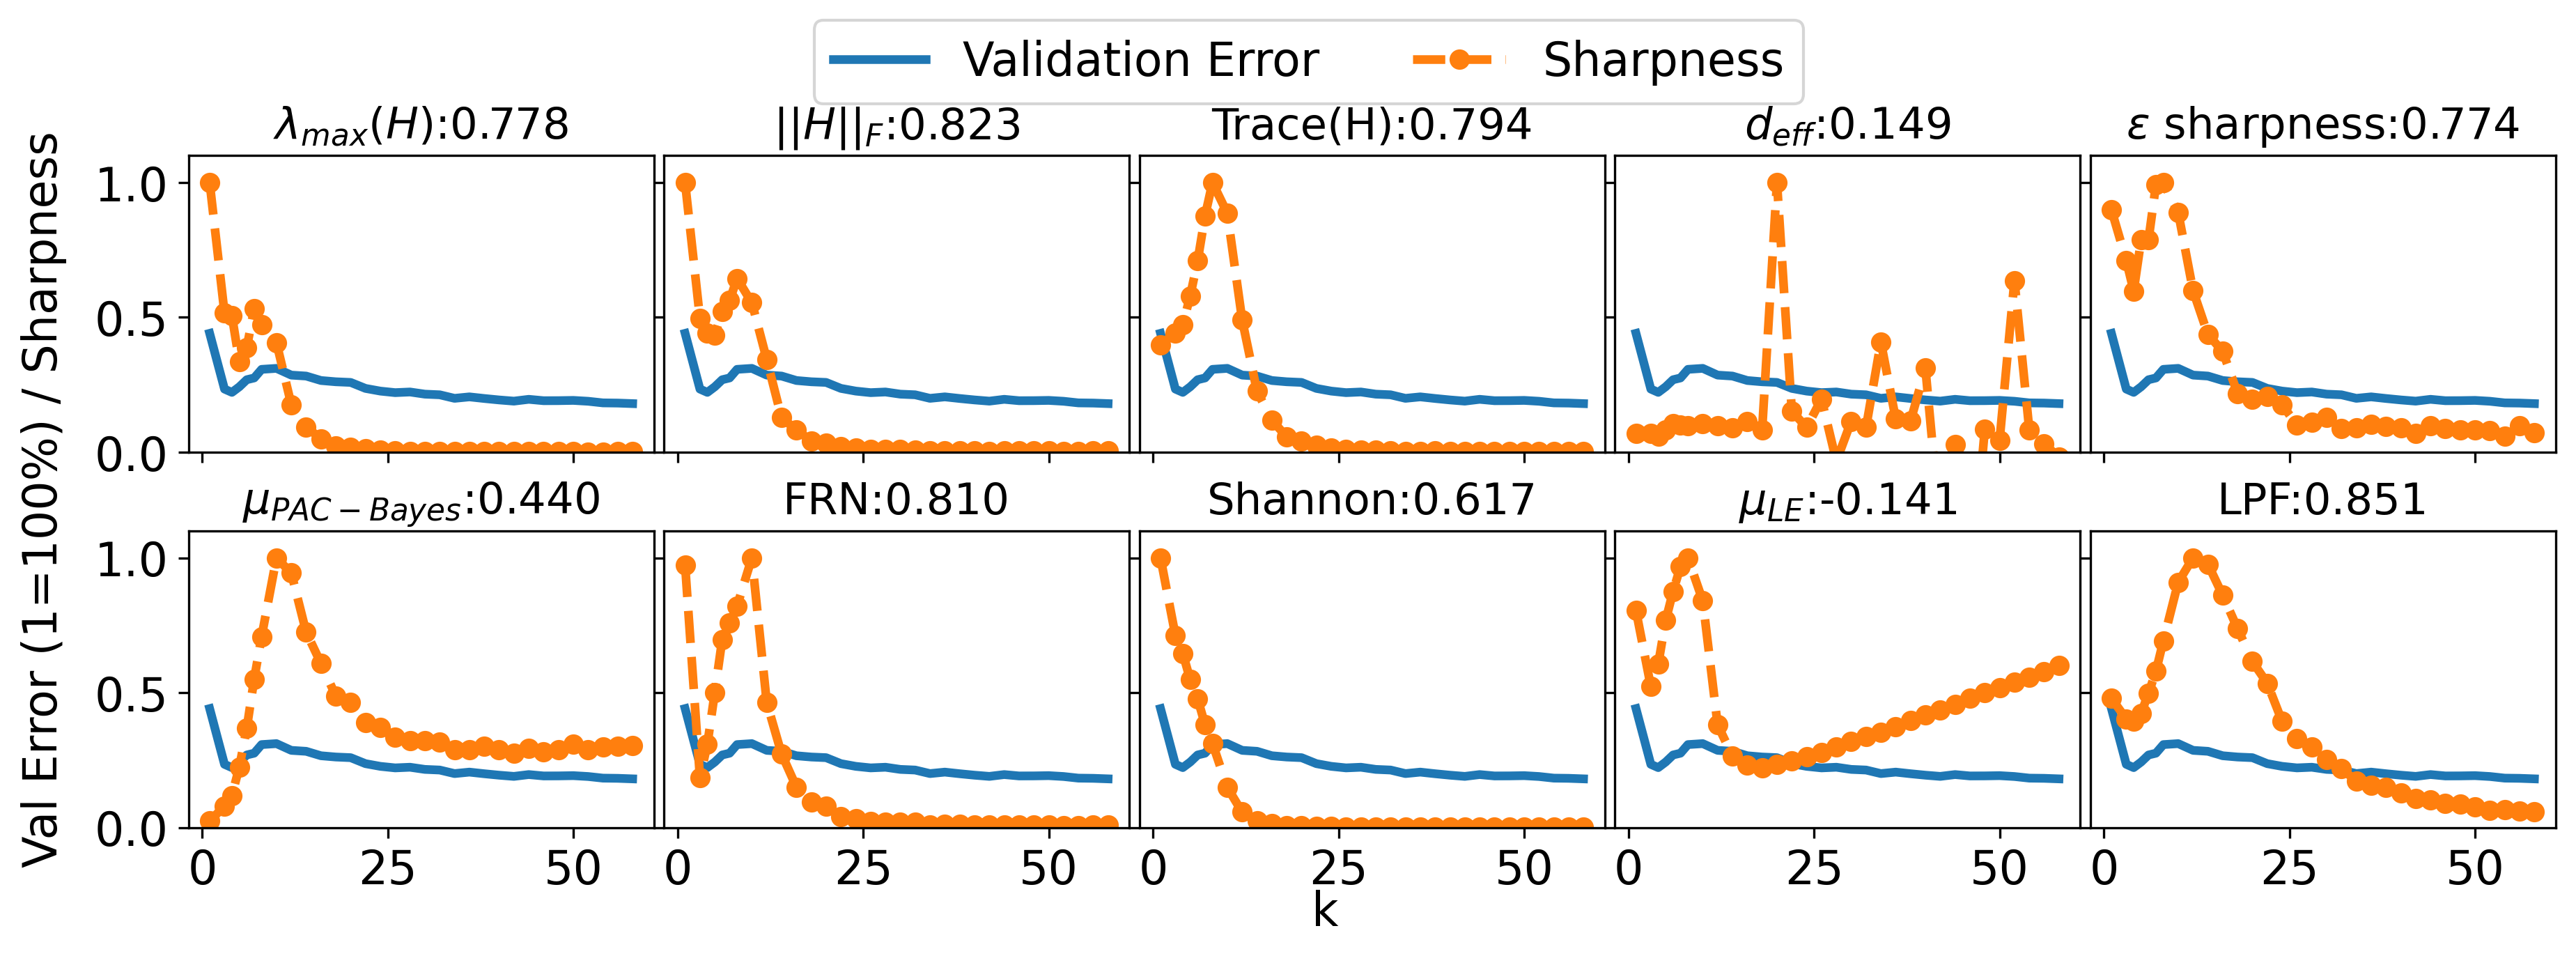

In [14]:
fig, axs = plt.subplots(2, 5, figsize=(12,4), sharex=True, sharey=True)

i=0
for meas,ax in zip(all_measures, axs.ravel()):
    ax.plot(widths, acc, label="", linewidth=3)
    ax.plot(widths, sharpness[i,:], label="", linewidth=3, marker='o', linestyle="--")
    ax.set_title(f"{labels[i]}:{scipy.stats.kendalltau(gen_gap, sharpness[i,:])[0]:0.3f}", fontsize=15)
    i+=1
    ax.set_ylim([0,1.1])

fig.legend(["Validation Error", "Sharpness"], ncol=2, bbox_to_anchor=(0.7, 1.1))
fig.text(0.5, -0.01, 'k', ha='center')
fig.text(-0.02, 0.5, 'Val Error (1=100%) / Sharpness', va='center', rotation='vertical')
plt.tight_layout(pad=0.5, w_pad=0.0, h_pad=0.0)
fig.savefig("results/nips/dd.eps") 

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot2grid(shape=(3,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((3,6), (0,2), colspan=2, sharex=ax1)
ax3 = plt.subplot2grid((3,6), (0,4), colspan=2, sharex=ax1)
ax4 = plt.subplot2grid((3,6), (1,0), colspan=2, sharex=ax1)
ax5 = plt.subplot2grid((3,6), (1,2), colspan=2, sharex=ax1)
ax6 = plt.subplot2grid((3,6), (1,4), colspan=2, sharex=ax1)
ax7 = plt.subplot2grid((3,6), (2,1), colspan=2, sharex=ax1)
ax8 = plt.subplot2grid((3,6), (2,3), colspan=2, sharex=ax1)
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
# ax.plot(widths, gen_gap, linewidth=2, marker='o')

for i,meas in enumerate(all_measures,0):
    p = (int)(i / 3)
    q = i % 3
    axs[i].plot(widths, acc, label="Val Error", linewidth=2)
    axs[i].plot(widths, x[i,:], label=f"{labels[i]}",linewidth=3, linestyle="--")
    axs[i].legend(fontsize=13, loc=1)
plt.tight_layout()
fig.text(0.5, -0.01, 'Resnet Width', ha='center')
fig.text(-0.02, 0.5, 'Test Error / Sharpness', va='center', rotation='vertical')
plt.savefig("results/dd.png")

In [ ]:
len(widths)